# A/B Testing with Amazon SageMaker

In production ML workflows, data scientists and data engineers frequently try to improve their models in various ways, such as by performing [Perform Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), training on additional or more-recent data, and improving feature selection. Performing A/B testing between a new model and an old model with production traffic can be an effective final step in the validation process for a new model. In A/B testing, you test different variants of your models and compare how each variant performs relative to each other. You then choose the best-performing model to replace a previously-existing model new version delivers better performance than the previously-existing version.

Amazon SageMaker enables you to test multiple models or model versions behind the same endpoint using production variants. Each production variant identifies a machine learning (ML) model and the resources deployed for hosting the model. You can distribute endpoint invocation requests across multiple production variants by providing the traffic distribution for each variant, or you can invoke a specific variant directly for each request.

In this notebook we'll:
* Evaluate models by invoking specific variants
* Gradually release a new model by specifying traffic distribution

### Prerrequisites

First we ensure we have an updated version of boto3, which includes the latest SageMaker features:

In [29]:
!pip install -U awscli

    100% |████████████████████████████████| 1.2MB 10.2MB/s ta 0:00:01
    100% |████████████████████████████████| 6.2MB 6.9MB/s eta 0:00:01
Requirement not upgraded as not directly required: docutils<0.16,>=0.10 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from awscli) (0.14)
Requirement not upgraded as not directly required: rsa<=3.5.0,>=3.1.2 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from awscli) (3.4.2)
Requirement not upgraded as not directly required: s3transfer<0.4.0,>=0.3.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from awscli) (0.3.3)
Requirement not upgraded as not directly required: PyYAML<5.4,>=3.10 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from awscli) (5.3.1)
Requirement not upgraded as not directly required: colorama<0.4.4,>=0.2.5 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from awscli) (0.3.9)
Requirement not upgraded as not directly requ

## Configuration

Let's set up some required imports and basic initial variables:

In [2]:
%%time
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-VariantTargeting"

CPU times: user 1.09 s, sys: 109 ms, total: 1.2 s
Wall time: 1.31 s


## Step 1: Create and deploy the models

### First, we upload our pre-trained models to Amazon S3
This code uploads two pre-trained XGBoost models that are ready for you to deploy. These models were trained using the XGB Churn Prediction Notebook in SageMaker. You can also use your own pre-trained models in this step. If you already have a pretrained model in Amazon S3, you can add it by specifying the s3_key.

The models in this example are used to predict the probability of a mobile customer leaving their current mobile operator. The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

In [3]:
model_url = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model2.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://sagemaker-us-east-2-799622031015/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model.tar.gz',
 's3://sagemaker-us-east-2-799622031015/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model2.tar.gz')

### Next, we create our model definitions
Start with deploying the pre-trained churn prediction models. Here, you create the model objects with the image and model data.

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri

model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = get_image_uri(boto3.Session().region_name, "xgboost", "0.90-1")
image_uri2 = get_image_uri(boto3.Session().region_name, "xgboost", "0.90-2")

sm_session.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

sm_session.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

	get_image_uri(region, 'xgboost', '0.90-2').


'DEMO-xgb-churn-pred2-2020-06-05-15-27-29'

### Create variants

We now create two variants, each with its own different model (these could also have different instance types and counts).

We set an initial_weight of “1” for both variants: this means 50% of our requests go to Variant1, and the remaining 50% of all requests to Variant2. (The sum of weights across both variants is 2 and each variant has weight assignment of 1. This implies each variant receives 1/2, or 50%, of the total traffic.)

In [5]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant1",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=model_name2,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant2",
    initial_weight=1,
)

(variant1, variant2)

({'ModelName': 'DEMO-xgb-churn-pred-2020-06-05-15-27-29',
  'InstanceType': 'ml.m5.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1},
 {'ModelName': 'DEMO-xgb-churn-pred2-2020-06-05-15-27-29',
  'InstanceType': 'ml.m5.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1})

### Deploy

Let's go ahead and deploy our two variants to a SageMaker endpoint:

In [6]:
endpoint_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sm_session.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

EndpointName=DEMO-xgb-churn-pred-2020-06-05-15-27-31
-------------!

'DEMO-xgb-churn-pred-2020-06-05-15-27-31'

## Step 2: Invoke the deployed models

You can now send data to this endpoint to get inferences in real time.

This step invokes the endpoint with included sample data for about 2 minutes. 

In [7]:
# get a subset of test data for a quick test
!tail -120 test_data/test-dataset-input-cols.csv > test_data/test_sample_tail_input_cols.csv
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
        time.sleep(0.5)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2020-06-05-15-27-31. 
Please wait...
........................................................................................................................Done!


### Invocations per variant

Amazon SageMaker emits metrics such as Latency and Invocations (full list of metrics [here](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) for each variant in Amazon CloudWatch. Let’s query CloudWatch to get number of Invocations per variant, to show how invocations are split across variants:

In [8]:
import pandas as pd

cw = boto3.Session().client("cloudwatch")


def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant1["VariantName"], start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant2["VariantName"], start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting two minutes for initial metric creation...


,Variant1,Variant2
Timestamp,,
2020-06-05 15:34:00+00:00,44.0,60.0
2020-06-05 15:35:00+00:00,7.0,9.0


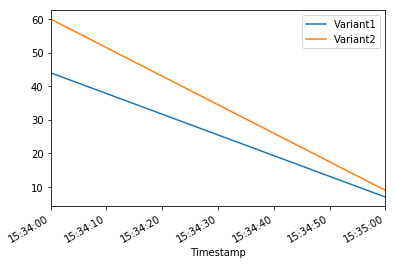

In [9]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

### Invoke a specific variant

Now, let’s use the new feature that was released today to invoke a specific variant. For this, we simply use the new parameter to define which specific ProductionVariant we want to invoke. Let us use this to invoke Variant1 for all requests.

In [10]:
import numpy as np

predictions = ""

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant1["VariantName"],
        )
        predictions = ",".join([predictions, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=",")

# Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2020-06-05-15-27-31. 
Please wait...
........................................................................................................................Done!


When we again check the traffic per variant, this time we see that the number of invocations only incremented for Variant1, because all invocations were targeted at that variant:

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,Variant1,Variant2
Timestamp,,
2020-06-05 15:34:00+00:00,44.0,60.0
2020-06-05 15:35:00+00:00,7.0,9.0
2020-06-05 15:36:00+00:00,99.0,NaN


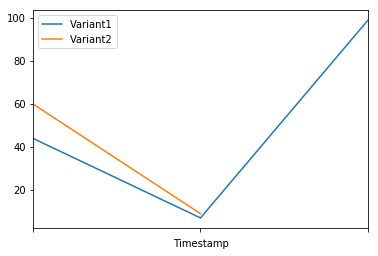

In [11]:
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

## Step 3: Evaluate variant performance

### Evaluating Variant 1

Using the new targeting feature, let us evaluate the accuracy, precision, recall, F1 score, and ROC/AUC for Variant1:

Accuracy: 0.9583333333333334
Precision: 0.9411764705882353
Recall: 0.8
F1 Score: 0.8648648648648648
AUC is 0.895


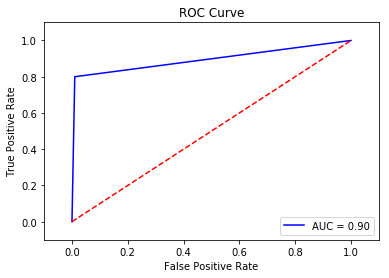

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Let's get the labels of our test set; we will use these to evaluate our predictions
!tail -121 test_data/test-dataset.csv > test_data/test_dataset_sample_tail.csv
df_with_labels = pd.read_csv("test_data/test_dataset_sample_tail.csv")
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()

# Calculate accuracy
accuracy = sum(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = sum(preds[preds == 1] == labels[preds == 1]) / len(preds[preds == 1])
print(f"Precision: {precision}")

# Calculate recall
recall = sum(preds[preds == 1] == labels[preds == 1]) / len(labels[labels == 1])
print(f"Recall: {recall}")

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Calculate AUC
auc = round(roc_auc_score(labels, preds), 4)
print("AUC is " + repr(auc))

fpr, tpr, _ = metrics.roc_curve(labels, preds)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

### Next, we collect data for Variant2

In [13]:
predictions2 = ""
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant2["VariantName"],
        )
        predictions2 = ",".join([predictions2, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert to numpy array
pred_np2 = np.fromstring(predictions2[1:], sep=",")

# Convert to binary predictions
thresh = 0.5
preds2 = np.where(pred_np2 > threshold, 1, 0)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2020-06-05-15-27-31. 
Please wait...
........................................................................................................................Done!


When we again check the traffic per variant, this time we see that the number of invocations only incremented for Variant2, because all invocations were targeted at that variant:

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,Variant1,Variant2
Timestamp,,
2020-06-05 15:34:00+00:00,44.0,60.0
2020-06-05 15:35:00+00:00,7.0,9.0
2020-06-05 15:36:00+00:00,99.0,NaN
2020-06-05 15:37:00+00:00,21.0,55.0
2020-06-05 15:38:00+00:00,NaN,65.0


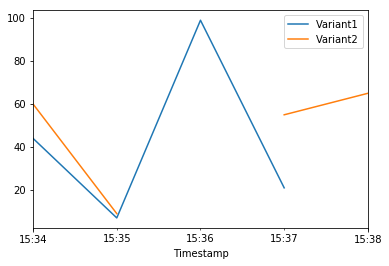

In [14]:
time.sleep(60)  # give metrics time to catch up
plot_endpoint_metrics()

### Evaluating Variant2 

Accuracy: 0.9583333333333334
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
AUC is 0.915


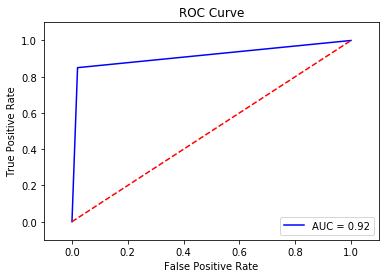

In [15]:
# Calculate accuracy
accuracy2 = sum(preds2 == labels) / len(labels)
print(f"Accuracy: {accuracy2}")

# Calculate precision
precision2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(preds2[preds2 == 1])
print(f"Precision: {precision2}")

# Calculate recall
recall2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(labels[labels == 1])
print(f"Recall: {recall2}")

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print(f"F1 Score: {f1_score2}")

auc2 = round(roc_auc_score(labels, preds2), 4)
print("AUC is " + repr(auc2))

fpr2, tpr2, _ = metrics.roc_curve(labels, preds2)

plt.title("ROC Curve")
plt.plot(fpr2, tpr2, "b", label="AUC = %0.2f" % auc2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

We see that Variant2 is performing better for most of our defined metrics, so this is the one we’re likely to choose to dial up in production.

## Step 4: Dialing up our chosen variant in production

Now that we have determined Variant2 to be better as compared to Variant1, we will shift more traffic to it. 

We can continue to use TargetVariant to continue invoking a chosen variant. A simpler approach is to update the weights assigned to each variant using UpdateEndpointWeightsAndCapacities. This changes the traffic distribution to your production variants without requiring updates to your endpoint. 

Recall our variant weights are as follows:

In [16]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

We'll first write a method to easily invoke our endpoint (a copy of what we had been previously doing):

In [17]:
def invoke_endpoint_for_two_minutes():
    with open("test_data/test-dataset-input-cols.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)

We invoke our endpoint for a bit, to show the even split in invocations:

..............................................................................................................................................................................................................................................................................................................................................

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,Variant1,Variant2
Timestamp,,
2020-06-05 15:39:00+00:00,11.0,15.0
2020-06-05 15:40:00+00:00,37.0,22.0
2020-06-05 15:41:00+00:00,35.0,24.0
2020-06-05 15:42:00+00:00,28.0,31.0
2020-06-05 15:43:00+00:00,35.0,24.0
2020-06-05 15:44:00+00:00,24.0,17.0


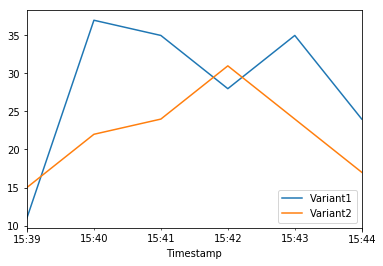

In [18]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

Now let us shift 75% of the traffic to Variant2 by assigning new weights to each variant using UpdateEndpointWeightsAndCapacities. Amazon SageMaker will now send 75% of the inference requests to Variant2 and remaining 25% of requests to Variant1. 

In [19]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 25, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 75, "VariantName": variant2["VariantName"]},
    ],
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-2:799622031015:endpoint/demo-xgb-churn-pred-2020-06-05-15-27-31',
 'ResponseMetadata': {'RequestId': '43463972-7344-491b-9067-f260ad30b2e2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '43463972-7344-491b-9067-f260ad30b2e2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Fri, 05 Jun 2020 15:45:33 GMT'},
  'RetryAttempts': 0}}

In [20]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
..........................................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

Now let's check how that has impacted invocation metrics:

..............................................................................................................................................................................................................................................................................................................................................

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,Variant1,Variant2
Timestamp,,
2020-06-05 15:39:00+00:00,11.0,15.0
2020-06-05 15:40:00+00:00,37.0,22.0
2020-06-05 15:41:00+00:00,35.0,24.0
2020-06-05 15:42:00+00:00,28.0,31.0
2020-06-05 15:43:00+00:00,35.0,24.0
2020-06-05 15:44:00+00:00,33.0,26.0
2020-06-05 15:45:00+00:00,8.0,5.0
2020-06-05 15:46:00+00:00,2.0,22.0
2020-06-05 15:47:00+00:00,19.0,41.0


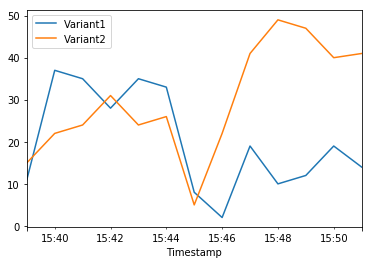

In [21]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

We can continue to monitor our metrics and when we're satisfied with a variant's performance, we can route 100% of the traffic over the variant. We used UpdateEndpointWeightsAndCapacities to update the traffic assignments for the variants. The weight for Variant1 is set to 0 and the weight for Variant2 is set to 1. Therefore, Amazon SageMaker will send 100% of all inference requests to Variant2.

In [22]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 0, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 1, "VariantName": variant2["VariantName"]},
    ],
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
...........................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

..............................................................................................................................................................................................................................................................................................................................................

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,Variant1,Variant2
Timestamp,,
2020-06-05 15:39:00+00:00,11.0,15.0
2020-06-05 15:40:00+00:00,37.0,22.0
2020-06-05 15:41:00+00:00,35.0,24.0
2020-06-05 15:42:00+00:00,28.0,31.0
2020-06-05 15:43:00+00:00,35.0,24.0
2020-06-05 15:44:00+00:00,33.0,26.0
2020-06-05 15:45:00+00:00,8.0,5.0
2020-06-05 15:46:00+00:00,2.0,22.0
2020-06-05 15:47:00+00:00,19.0,41.0


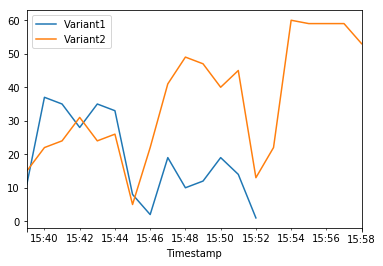

In [23]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

The Amazon CloudWatch metrics for the total invocations for each variant below shows us that all inference requests are being processed by Variant2 and there are no inference requests processed by Variant1.

You can now safely update your endpoint and delete Variant1 from your endpoint. You can also continue testing new models in production by adding new variants to your endpoint and following steps 2 - 4. 

## Delete the endpoint

If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges.

In [31]:
sm_session.delete_endpoint(endpoint_name)